<a href="https://colab.research.google.com/github/girotodenis/ReconhecimentoImagemVisaoComputacional/blob/master/Projeto4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOME COMPLETO DOS INTEGRANTES DO GRUPO:
**Davi Miranda Gonçalves**, 
**Denis SIlva Giroto**,
**Naiara Moura Pires**

MATRÍCULAS DOS INTEGRANTES DO GRUPO:
**1931143030**,
**1931143029**,
**1931143033**

In [7]:
!git clone -l -s https://github.com/girotodenis/ReconhecimentoImagemVisaoComputacional.git projeto
#%cd cloned-repo
!ls

Cloning into 'projeto'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 187 (delta 0), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (187/187), 88.46 MiB | 38.56 MiB/s, done.
Resolving deltas: 100% (79/79), done.
adc.json       foto_1500.png  foto_2500.png  foto_500.png  projetolixo	vvv
foto_1000.png  foto_2000.png  foto_3000.png  projeto	   sample_data


In [8]:
from google.colab.patches import cv2_imshow

import numpy as np
import cv2
import imutils


In [9]:
net = cv2.dnn.readNet('./projeto/yolov3-tiny.weights','./projeto/yolov3-tiny.cfg')

In [10]:
classes = []
with open('./projeto/coco.names','r')as f:
  classes = [line.strip() for line in f.readlines()]
print(classes)

layer_names = net.getLayerNames()
outputLayers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
print(outputLayers)

cores = np.random.uniform(0,255,size=(len(classes), 3))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['yolo_16', 'yolo_23']


In [11]:
cap = cv2.VideoCapture('./projeto/videos/Car2165.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter('./projeto/videos/carros2165_novo.mp4', cv2.VideoWriter_fourcc(*'DIVX'),20,(width, height))

print(width, height)
if cap.isOpened() == False:
    print('error file not found')
    

1280 720


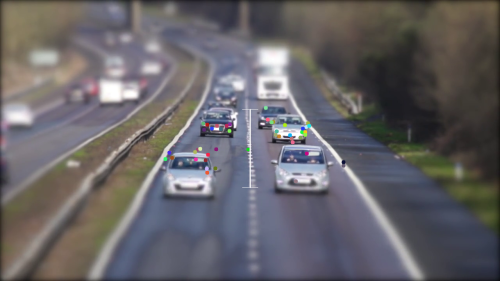

500 [[470, 395, 49, 28], [442, 428, 93, 49], [725, 422, 101, 45]] [0.6921857, 0.5254644, 0.6525184] [2, 2, 2]


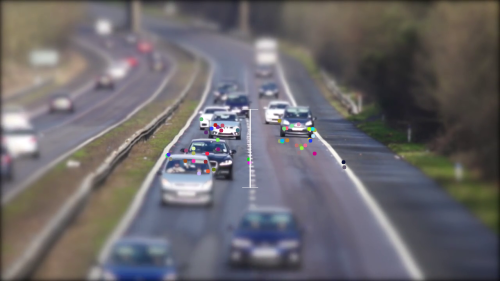

1000 [[514, 396, 43, 34]] [0.57628083] [2]


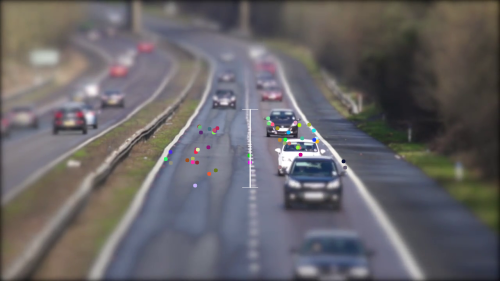

1500 [[755, 425, 98, 56]] [0.8180933] [2]


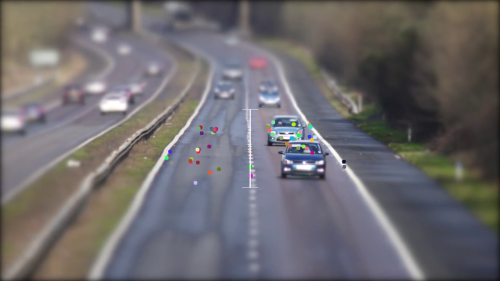

2000 [[754, 400, 49, 36]] [0.5881066] [2]


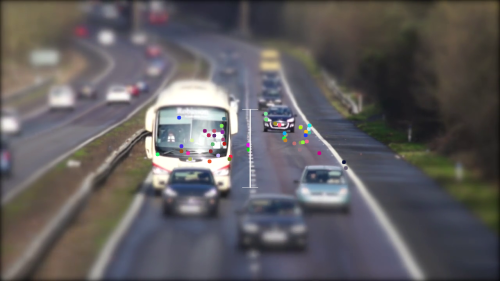

2500 [[787, 451, 110, 51]] [0.6160483] [2]


error: ignored

In [19]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
color = np.random.randint(0,255,(100,3))


cod_frame=0
while cap.isOpened():
    cod_frame+=1
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if ret == True:

        if cod_frame == 1:
          old_frame = frame
          mask = np.zeros_like(old_frame)
          old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
          p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
          a,b = new.ravel()
          c,d = old.ravel()
          mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
          frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)

        cv2.line(frame,(620 ,280),(660, 280),(255,255,255), 1)
        cv2.line(frame,(620 ,480),(660, 480),(255,255,255), 1)
        cv2.line(frame,(640 ,280),(640, 480),(255,255,255), 2)

        #BGR -> RGB
        blob = cv2.dnn.blobFromImage(frame, 0.00392,(320,320),(0,0,0),True)
        net.setInput(blob)
        outs = net.forward(outputLayers)

        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
          for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence>0.5:
              center_x = int(detection[0]*width)
              center_y = int(detection[1]*height)
              w = int(detection[2]*width)
              h = int(detection[3]*height)
              x = int(center_x - w/2)
              y = int(center_y - h/2)
              if y>280 and y<480 :
                boxes.append([x,y,w,h])
                confidences.append(confidence)
                class_ids.append(class_id)

        if cod_frame % 500 == 0:
          nome_foto = 'foto_'+str(cod_frame)+'.png'
          cv2.imwrite(nome_foto, imutils.resize(frame, width=500))
          cv2_imshow(cv2.imread(nome_foto))
          print(cod_frame, boxes, confidences, class_ids)

        #indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.6)

        for i in range(len(boxes)):
          #if i in indexes:
          x,y,w,h = boxes[i]
          label = str(classes[class_ids[i]])
          label += ' '+ str(round(confidences[i],2))
          cor = cores[class_ids[i]]
          cv2.rectangle(frame,(x ,y),(x+w, y+h),cor, 2)
          cv2.putText(frame, label, (x, y+30), cv2.FONT_HERSHEY_PLAIN,1,(255,255,255),2)

        #frame = zoom_selecionado(frame, kernel)
        #cv2_imshow('frame', frame)
        writer.write(frame)
    else:
        break
cap.release()
writer.release()

In [ ]:
carros = {'nome':{'ponto':(0,0),'rastros':np.array([[]])}}
for carro in carros:
  print(carro)
  print(carros[carro]['rastros'])


In [15]:
x = [[1]]
x[0][0]

1